In [1]:
import numpy as np
import pandas as pd

In [2]:
data_filename = "framingham.csv"

In [ ]:
df = pd.read_csv(data_filename)

In [4]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
df.TenYearCHD.value_counts()

0    3596
1     644
Name: TenYearCHD, dtype: int64

In [71]:
df.shape

(4240, 16)

In [6]:
# imbalanced dataset, while we are k with false positives we do not want to have false negatives.

In [7]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [8]:
df.male.value_counts()

0    2420
1    1820
Name: male, dtype: int64

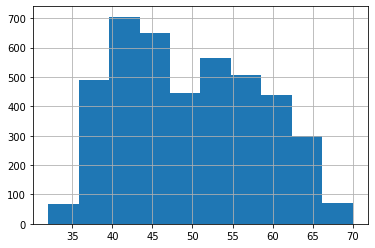

In [9]:
df.age.hist()

In [10]:
# 1 = Some High School; 2 = High School or GED; 3 = Some College or Vocational School; 4 = college
# this is essentially categorical variable, we could one-hot encode it
df.education.value_counts()

1.0    1720
2.0    1253
3.0     689
4.0     473
Name: education, dtype: int64

In [11]:
df.currentSmoker.value_counts()

0    2145
1    2095
Name: currentSmoker, dtype: int64

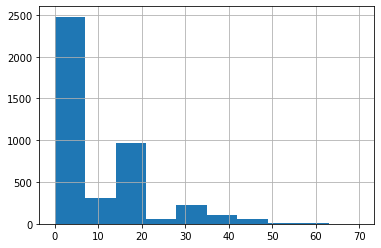

In [12]:
df.cigsPerDay.hist()

In [13]:
# BP Meds: whether or not the patient was on blood pressure medication (Nominal)
df.BPMeds.value_counts()

0.0    4063
1.0     124
Name: BPMeds, dtype: int64

In [14]:
# Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
df.prevalentStroke.value_counts()

0    4215
1      25
Name: prevalentStroke, dtype: int64

In [15]:
#  Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
df.prevalentHyp.value_counts()

0    2923
1    1317
Name: prevalentHyp, dtype: int64

In [16]:
# Diabetes: whether or not the patient had diabetes (Nominal)
df.diabetes.value_counts()

0    4131
1     109
Name: diabetes, dtype: int64

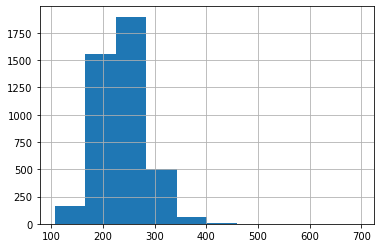

In [17]:
# Tot Chol: total cholesterol level (Continuous)
df.totChol.hist()

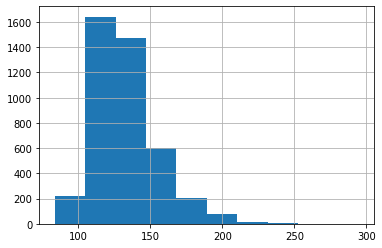

In [18]:
# Sys BP: systolic blood pressure
df.sysBP.hist()

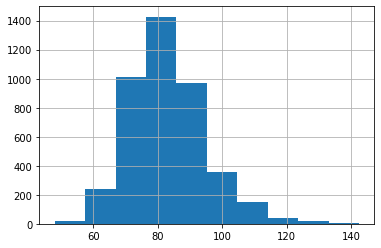

In [19]:
# Dia BP: diastolic blood pressure
df.diaBP.hist()

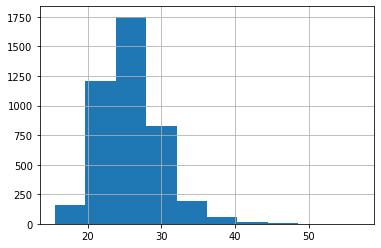

In [20]:
# BMI: Body Mass Index 
df.BMI.hist()

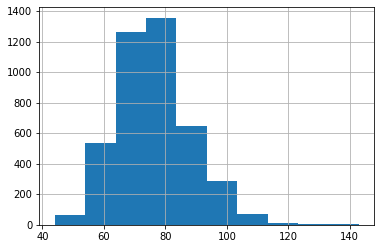

In [21]:
# Heart Rate
df.heartRate.hist()

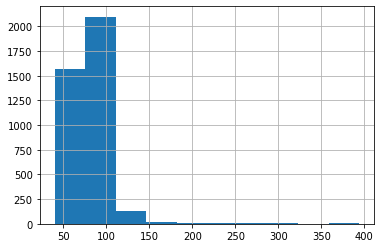

In [22]:
# glucose level
df.glucose.hist()

### Data analysis

In [23]:
# blood pressures are correlated as expected
df[['diaBP', 'sysBP']].corr()

,diaBP,sysBP
diaBP,1.000000,0.783952
sysBP,0.783952,1.000000


In [24]:
df[df.prevalentHyp == 1]['diaBP'].mean(), df[df.prevalentHyp == 1]['diaBP'].std(), df[df.prevalentHyp == 0]['diaBP'].mean(), df[df.prevalentHyp == 0]['diaBP'].std()

(93.82384206529993, 11.373799791691479, 77.97485460143687, 8.335668430126276)

In [25]:
df[df.prevalentHyp == 1]['sysBP'].mean(), df[df.prevalentHyp == 1]['sysBP'].std(), df[df.prevalentHyp == 0]['sysBP'].mean(), df[df.prevalentHyp == 0]['sysBP'].std()

(155.21943811693242,
 20.785707957804732,
 122.05251453985632,
 12.957100133913547)

In [67]:
df[df.currentSmoker == 0].cigsPerDay.sum()

0.0

In [70]:
df[(df.currentSmoker == 1) & (df.cigsPerDay == 0)]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


## Data transformation

- algorithms:
    - XGB: no need to prefill missing values
    - logistic regression: do need to prefill missing values and also normilize/standartize features
- Take care of missing values:
    - education: fill with 1
    - cigsPerDay: if non smoker fill with zero, if smoker with average
    - BPMeds: fill with 0
    - totChol, BMI, heartrate, glucose: fill with average
- dataset imbalance:
    - take part of data with no heart desease to keep balance 50/50
    - repeat portion with heart desease = 1
    - repeat with small variations (noise in data)
- categorical variable education:
    - can leave like this, since it is ordered
    - or turn into one-hot encoding
- No going to generate new features
    - we could probably create features like heavy smoker, or high blood pressure, but no smart features

- 4 versions of data - 2 for logistic and 2 for XGB:
    - First take care of imbalance (do this first)
        - randomly choose rows from the [heart desease = 0] to balance data
        - randomly sample a line from the population with heart desease and:
            - modify each of the variables (totChol, sysBP, diaBP, BMI, heartRate, glucose) with probability 50%
            - modification epsilon is normally distributed with sigma = 0.1 * original sigma
    - For logistic regression:
        - fill missing values, normalize/standartize, keep education rational
    - for XGB:
        - keep missing values, one-hot-encode education

We will load to S3 3 files for each version of data: full, training (70%) and validation/test (30%)

In [26]:
df.TenYearCHD.value_counts()

0    3596
1     644
Name: TenYearCHD, dtype: int64

#### Create sampled dataframe

In [27]:
#  this will give sample indexes from TenYearCHD = 0
sample_idxs = np.random.choice(3596, 644, replace='False')

In [28]:
df_s = pd.concat([df[df.TenYearCHD == 0].iloc[sample_idxs], df[df.TenYearCHD == 1]], ignore_index=True)

#### Create dataframe with generated data

In [29]:
df_chd = df[df.TenYearCHD == 1]

In [30]:
# note that we calculate this only for data TenYearCHD == 1, this is important
# We divede std to a constant, we want to vary slightly, but not to add too much noise
std_factor = 50
variables_std = df_chd[['totChol','sysBP','diaBP','BMI','heartRate','glucose']].std().values / std_factor
[std_totChol, std_sysBP, std_diaBP, std_BMI, std_heartRate, std_glucose] = variables_std
std_var = {'std_totChol':std_totChol, 'std_sysBP':std_sysBP, 'std_diaBP':std_diaBP, 
           'std_BMI':std_BMI, 'std_heartRate':std_heartRate, 'std_glucose':std_glucose}
std_var

{'std_totChol': 0.9615139622388316,
 'std_sysBP': 0.5338056464808075,
 'std_diaBP': 0.2805380038986249,
 'std_BMI': 0.0904427441096042,
 'std_heartRate': 0.24439914066393156,
 'std_glucose': 0.8228150412965133}

In [31]:
def MakeNewRow(df_chd, stds):
    i = np.random.choice(df_chd.shape[0])
    row = df_chd.iloc[i].copy()
    for var in ['totChol','sysBP','diaBP','BMI','heartRate','glucose']:
        row[var] = row[var] + np.random.normal(0, stds['std_'+var])
        
    return row.values

In [32]:
MakeNewRow(df_chd, std_var)

array([  0.        ,  40.        ,   2.        ,   1.        ,
        20.        ,   0.        ,   0.        ,   0.        ,
         0.        , 270.62046217, 138.05174342,  87.76011775,
        27.36464704,  80.10972564,          nan,   1.        ])

In [33]:
extra_rows = df.TenYearCHD.value_counts()[0] - df.TenYearCHD.value_counts()[1]
extra_rows

2952

In [34]:
extra_data = []
for _ in range(extra_rows):
    extra_data.append(MakeNewRow(df_chd, std_var))
    
extra_df = pd.DataFrame(extra_data, columns = df.columns, dtype = df.dtypes.values)

In [35]:
extra_df.head(2)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,58,2,0,0,0,0,0,0,190.474,133.003,66.476,23.0779,65.1865,69.5716,1
1,1,49,1,1,20,0,0,0,0,246.301,150.185,87.8475,27.9371,74.658,76.5029,1


In [36]:
df_g = pd.concat([df[df.TenYearCHD == 0], df[df.TenYearCHD == 1], extra_df], ignore_index=True)

## Prepare data for logistic and XGB

Now we have df_s with sample data and df_g with generated data. 

I will define functions to process data and prepare it for logistic regression or XGB

- For logistic regression:
    - Take care of missing values:
        - education: fill with 1
        - cigsPerDay: if non smoker fill with zero, if smoker with average
        - BPMeds: fill with 0
        - totChol, BMI, heartrate, glucose: fill with average 
    - normalize/standartize, keep education rational
- for XGB:
    - keep missing values, one-hot-encode education

In [37]:
def DataPrepLogistic(df):
    # fill missing values for education, cigsPerDay, BPMeds, totChol, BMI, heartrate, glucose
    df['education'] = df['education'].fillna(1)
    df['BPMeds'] = df['BPMeds'].fillna(0)
    df['totChol'] = df['totChol'].fillna(round(df_g['totChol'].mean(), 2))
    df['BMI'] = df['BMI'].fillna(round(df_g['BMI'].mean(), 2))
    df['heartRate'] = df['heartRate'].fillna(round(df_g['heartRate'].mean(), 2))
    df['glucose'] = df['glucose'].fillna(round(df_g['glucose'].mean(), 2))
    
    mean_cigsperday = round(df[df.cigsPerDay>0]['cigsPerDay'].mean(), 2)
    df.loc[df.cigsPerDay.isna(), 'cigsPerDay'] = mean_cigsperday * df.loc[df.cigsPerDay.isna(), 'currentSmoker']
    
    # normalize cigsPerDay, education
    df.cigsPerDay = (df.cigsPerDay - df.cigsPerDay.min()) / (df.cigsPerDay.max() - df.cigsPerDay.min())
    df.education = (df.education - df.education.min()) / (df.education.max() - df.education.min())
    
    # standartize totChol, sysBP, diaBP, BMI, heartRate, glucose
    df.totChol = (df.totChol - df.totChol.mean()) / df.totChol.std()
    df.sysBP = (df.sysBP - df.sysBP.mean()) / df.sysBP.std()
    df.diaBP = (df.diaBP - df.diaBP.mean()) / df.diaBP.std()
    df.BMI = (df.BMI - df.BMI.mean()) / df.BMI.std()
    df.heartRate = (df.heartRate - df.heartRate.mean()) / df.heartRate.std()
    df.glucose = (df.glucose - df.glucose.mean()) / df.glucose.std()
    
    return df

In [38]:
# basically just one-hot-encode
def DataPrepXGB(df):
    df_temp = pd.get_dummies(df.education.fillna(1).astype(int), prefix='edu_')
    df = pd.concat([df, df_temp], axis=1)
    del df['education']
    
    return df

In [39]:
df_s_log = DataPrepLogistic(df_s.copy())

In [40]:
df_g_log = DataPrepLogistic(df_g.copy())

In [41]:
df_s_xgb = DataPrepXGB(df_s.copy())

In [42]:
df_g_xgb = DataPrepXGB(df_g.copy())

In [43]:
df_s_log.shape, df_g_log.shape, df_s_xgb.shape, df_g_xgb.shape

((1288, 16), (7192, 16), (1288, 19), (7192, 19))

In [44]:
display(df_s_log.head(2))
display(df_g_log.head(2))
display(df_s_xgb.head(2))
display(df_g_xgb.head(2))

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,61,0.000000,1,0.116667,0.0,0,1,0,-1.363866,-0.490258,-0.220428,0.870432,-0.509389,-0.310507,0
1,0,40,0.333333,0,0.000000,0.0,0,0,0,-0.808680,0.064464,0.007491,-0.913650,0.690763,-0.650461,0


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1.000000,0,0,0.0,0,0,0,-0.981608,-1.25401,-1.12886,0.195652,0.320504,-0.252630,0
1,0,46,0.333333,0,0,0.0,0,0,0,0.217672,-0.646401,-0.271838,0.605832,1.558891,-0.285283,0


,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,edu__1,edu__2,edu__3,edu__4
0,1,61,1,7.0,0.0,0,1,0,176.0,125.0,82.0,29.82,70.0,75.0,0,1,0,0,0
1,0,40,0,0.0,0.0,0,0,0,202.0,139.0,85.0,22.01,85.0,64.0,0,0,1,0,0


,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,edu__1,edu__2,edu__3,edu__4
0,1,39,0,0,0,0,0,0,195,106,70,26.97,80,77,0,0,0,0,1
1,0,46,0,0,0,0,0,0,250,121,81,28.73,95,76,0,0,1,0,0


## Save data in SageMaker format

We are going to prepare 4 different data frames with different versions of the data and save it as 3 files in the format accepted by Sagemaker.

In [50]:
# save df in sagemaker format
def SaveFloatDF(df, name):
    df_temp = df.copy()
    
    col = list(df_temp.columns)
    idx = col.index('TenYearCHD')
    new_col = ['TenYearCHD'] + col[:idx] + col[idx+1:]
    df_temp = df_temp[new_col]
    for col in df_temp.columns:
        df_temp[col] = df_temp[col].astype(float)
    
    df_temp.to_csv(name, header=False, index=False)

In [63]:
# save df in sagemaker format
def SaveDF(df, name):
    col = list(df.columns)
    idx = col.index('TenYearCHD')
    new_col = ['TenYearCHD'] + col[:idx] + col[idx+1:]
    df = df[new_col]
    
    df.to_csv(name, header=False, index=False)

In [64]:
def SplitAndSave(df, tr_percentage, name_prefix):
    train_len = int(df.shape[0] * tr_percentage / 2)
    half = int(df.shape[0]/2)

    dfx = df.sample(frac=1).sort_values('TenYearCHD').reset_index(drop=True)  
    
    idx_train = list(range(train_len)) + list(range(half, half + train_len))
    idx_test = list(range(train_len, half)) + list(range(half + train_len, half*2))

    SaveDF(dfx.iloc[idx_train], name_prefix + '_train.csv')
    SaveDF(dfx.iloc[idx_test], name_prefix + '_test.csv')

In [61]:
SaveDF(df_s_log, 'data_s_log_full.csv')
SaveDF(df_g_log, 'data_g_log_full.csv')
SaveDF(df_s_xgb, 'data_s_xgb_full.csv')
SaveDF(df_g_xgb, 'data_g_xgb_full.csv')

In [65]:
SplitAndSave(df_s_log, 0.7, 'data_s_log')
SplitAndSave(df_g_log, 0.7, 'data_g_log')
SplitAndSave(df_s_xgb, 0.7, 'data_s_xgb')
SplitAndSave(df_g_xgb, 0.7, 'data_g_xgb')

In [51]:
SaveDF(df_s_log, 'data_s_log_full.csv')
SplitAndSave(df_s_log, 0.7, 'data_s_log')